# Locally Weighted Regression

In this tutorial you will implement locally weighted regression (LWR) and understand the differences between LWR and linear regression.

The idea behind locally weighted regression (LWR) is to fit linear model in a local region about the point we want to do prediction at.
More formally, given the point $x$ at which we want to predict the output, we minimize the following loss function:
$$
\begin{align}
L(\theta) &= \sum_{i=1}^{N} w(x_i) (y_i - \theta^Tx_i)^2 \\
& = (X \theta - y)^T W (X \theta - y)
\end{align}
$$

\begin{equation}
X = \begin{bmatrix}
     - (x^{(1)})^T - \\
     \vdots \\
     - (x^{(n)})^T - \\
     \end{bmatrix}
     \in \mathbb{R}^{m \times n}
\qquad
y = \begin{bmatrix}
     y^{(1)} \\
     \vdots \\
     y^{(n)} \\
     \end{bmatrix}
\qquad
W =  \mathrm{diag} (w^{(i)}, \dots , w^{(n)})
\end{equation}

Where $w(x_i)$ is a weghting function, the purpose of this function is control the importance of each training example $(x_i, y_i)$ relative to the prediction point $x$, points which are close to $x$ will have larger weights while points which are far away from $x$ will have smaller weights.

A common choice of $w(x_i)$ is of the following form
$$
w(x_i) = \exp(-\frac{(x_i-x)^2}{2 \tau^2})
$$
Notice that when the example $x_i$ is close to the prediction point $x$ the weight is close to 1, and if $x_i$ is far away from $x$ the weight is close to 0.
$\tau$ controls the decay rate in which the weight falls from 1 to 0, the smaller the value of $\tau$ the quciker the weight falls to 0 as the point $x_i$ move further away from $x$, you can play interactively with in the next cell to understand the affect of $\tau$, $\tau$ is called the bandwidth parameter.


We can solve for $\theta$ with a slightly modified version of the normal equations
$$\theta = (X^T W X)^{-1} X^T W y$$

In [88]:
#@title Install some dependencies for the interactive plot

!pip install ipympl
!pip install plotly

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 516.3/516.3 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 17.8 MB/s eta 0:00:00
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pip/_vendor/pkg_resources/__init__.py", line 3108, in _dep_map
    return self.__dep_map
  File "/usr/local/lib/python3.10/dist-packages/pip/_vendor/pkg_resources/__init__.py", line 2901, in __getattr__
    raise AttributeError(attr)
AttributeError: _DistInfoDistribution__dep_map

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/base_command.py", line 169, in exc_logging_wrapper
    status = run_func(*args)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/req_command.py", line 242, in wrapper
    return func(self, options, args)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/commands/install.py",

In [1]:
#@title Interactive plot for the weight function


from google.colab import output
output.enable_custom_widget_manager()

import plotly.graph_objects as go
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
import numpy as np
from plotly.graph_objs.layout.shape import Line

@interact
def f(tau=widgets.FloatSlider(min=0.1, max=5, step=0.1, value=1)):
  x = 0
  x_i = np.arange(-10, 10, 0.1)
  w = np.exp(- (x_i - x)**2/(2*tau**2) )
  f = go.Figure(data=go.Line(x=x_i, y=w, mode='lines'))
  f.update_layout(yaxis_range=[0,1.2], width=500, height=500, title=r"$w(x_i) = \exp(-\frac{(x_i-x)^2}{2 \tau^2}), \ x=0$", xaxis_title="X value", yaxis_title="W value")
  f.show(renderer="colab")

display(f)


interactive(children=(FloatSlider(value=1.0, description='tau', max=5.0, min=0.1), Output()), _dom_classes=('w…

<function __main__.f(tau=FloatSlider(value=1.0, description='tau', max=5.0, min=0.1))>

After playing with the weighting function, write your observations in the next cell

In [2]:
# Your comments

The weight function has bell shape. It stretches  for large values of  $tau$ and tightens for small values of $tau$. Moreover, the number $\tau$ controls the width of the  neighborhood to take for each point. Indeed, for a given point $x_0$, we have:

$$
\Vert x_0 - x\Vert_2 >\tau ⟹ w(x_0) < 1
$$
In other words, points $x$ which are  $\pm \tau$ away from $x_0$, entails weights less than 1.

# Training Data

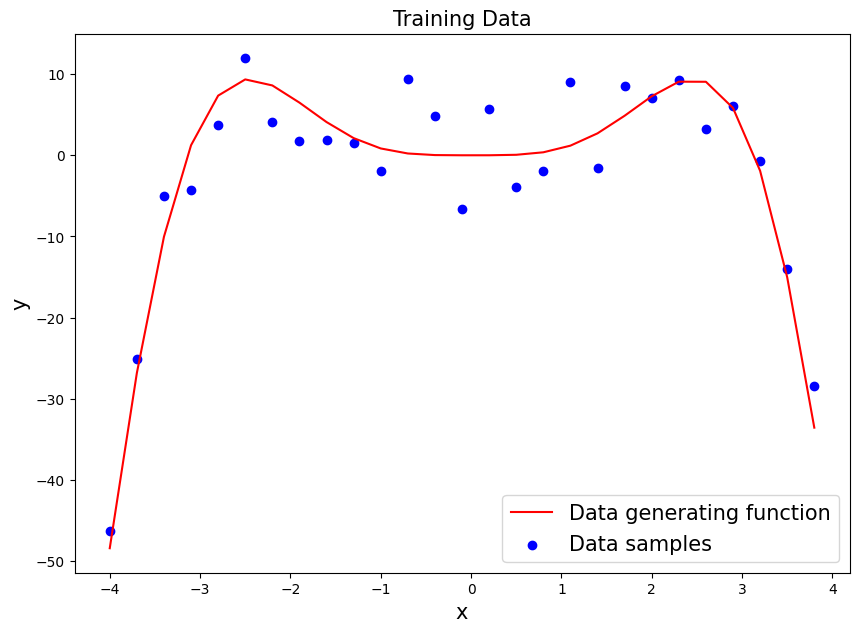

In [3]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = (10, 7)
matplotlib.rcParams['legend.fontsize'] = 15
import numpy as np

def generate_data(add_outlier=False):
  x = np.arange(-4, 4, 0.3)
  y =  x**3*np.sin(x)

  plt.plot(x, y, label="Data generating function", color="red")

  noise = np.random.randn(x.shape[0]) * 5
  y += noise

  if add_outlier:
    x = np.concatenate([x, [3, 5, -1, 1, 0]], axis=0)
    y = np.concatenate([y, [300, 200, 100, -100, 500]], axis=0)

  plt.scatter(x, y, label="Data samples", color="blue")
  font = {"size":15}
  plt.legend()
  plt.xlabel("x", fontdict=font)
  plt.ylabel("y", fontdict=font)
  plt.title("Training Data", fontdict=font)
  return x.reshape(-1, 1), y.reshape(-1, 1)


x_train, y_train = generate_data()

# LWR Model




#Add a column of ones to the feature matrix.
def add_ones(x):
  ones = np.ones(x.shape[0]).reshape(-1,1)
  x_with_ones = np.hstack((ones,x))

  return x_with_ones
x_with_ones = add_ones(x.reshape(-1,1))
x_with_ones

In [4]:
def add_ones(X):
    #Add a column of ones to the feature matrix.
    ones = np.ones(X.shape[0]).reshape(-1,1)
    x_with_ones = np.hstack((ones, X))

    return x_with_ones

In [5]:
def kernel(X, point, tau):
  #Compute the weight matrix
  diff = X[:,1]- point[1]

  k = np.exp(- diff**2/ (2* tau* tau))

  kern = np.diag(k)

  return kern

In [6]:
def local_weight(X,y, point, tau):
  # Compute the theta for a point "point"

    weight_matrix  = kernel(X, point, tau)

    theta = np.linalg.inv(X.T @ weight_matrix @ X)  @ (X.T @ weight_matrix @ y)
    return theta

In [7]:
def predict(X, y, x_pred, tau ):
    # make predictions for each point of x_pred

    y_pred = np.zeros((x_pred.shape[0],1))
    for i in range(x_pred.shape[0]):
      xpred = x_pred[i]
      y_pred[i] = (xpred @ local_weight(X, y, xpred, tau)).item()
    return y_pred

### The class: LocallyweightedRegression:

In [8]:
import numpy as np
import matplotlib.pyplot as plt

class LocallyWeightedRegression:

    def __init__(self, tau=0.1):

        self.tau = tau
        self.X = None
        self.y = None
        self.alpha = None
        self.without_reg = None

    def add_ones(self, X):
        #Add a column of ones to the feature matrix.
        ones = np.ones(X.shape[0]).reshape(-1,1)
        x_with_ones = np.hstack((ones, X))

        return x_with_ones

    def fit(self, X, y, without_reg = True, alpha = 0):
        #Fit the locally weighted regression model.
        """
        alpha: a regularization constant defaulted to zero.
        One can control the fit for different values of alpha.
        without_reg: a parameter to precise the regularization or not.
        It is defaulted to True, that is for the ideal case where the Least Square normal equation has unique solution.
        Use, without_reg = False if the normal equation has infinite solution, in other words when an error " LinAlgError: Singular matrix"
        occurs.
        """
        self.X = self.add_ones(X)
        self.y = y
        self.alpha = alpha
        self.without_reg = without_reg


    def kernel(self, point):
        #Compute the weight matrix
        diff = self.X[:,1] - point[1]

        k = np.exp(- diff **2 / (2* self.tau ** 2))

        kern = np.diag(k)

        return kern
        # diff = X[:,1] - point[1]
        # k = np.exp(- diff**2 / (2* tau* tau))

        # kern = np.diag(k)

        # return kern

    def local_weight(self, point, alpha=0):

      # Compute the theta for a point "point"
      """
      point: an array from the dataset.
      """
      weight_matrix  = self.kernel(point)

      identity_matrix = np.eye(self.X.shape[1], self.X.shape[1])

      theta = np.linalg.inv(self.X.T @ weight_matrix @ self.X +  alpha *  identity_matrix) @ (self.X.T @ weight_matrix @ self.y)

      return theta

    def predict(self, x_pred):
       # make predictions for each point of x_pred
      """
      x_pred: is the test inputs
      """
      y_pred = np.zeros((x_pred.shape[0],1))

      if self.without_reg:

        for i in range(y_pred.shape[0]):

          xpred = x_pred[i]

          y_pred[i] = (xpred @ self.local_weight(xpred)).item()

      for i in range(y_pred.shape[0]):


        xpred = x_pred[i]

        y_pred[i] = (xpred @ self.local_weight(xpred, self.alpha)).item()


      return y_pred

    def plot(self, x, y):
        """Plot the data and the fitted curve."""
        plt.scatter(self.X[:, 1], self.y, color='blue', label='Data')
        plt.plot(x, y, color='red', label='Fitted Curve')
        plt.xlabel('X')
        plt.ylabel('y')
        plt.title('Locally Weighted Regression')
        plt.legend()
        plt.show()

[[-1.15803290e+02]
 [-1.10776190e+02]
 [-1.05738801e+02]
 [-1.00691613e+02]
 [-9.56358840e+01]
 [-9.05739191e+01]
 [-8.55093998e+01]
 [-8.04477506e+01]
 [-7.53965284e+01]
 [-7.03658026e+01]
 [-6.53684808e+01]
 [-6.04205255e+01]
 [-5.55409937e+01]
 [-5.07518331e+01]
 [-4.60773764e+01]
 [-4.15435037e+01]
 [-3.71764806e+01]
 [-3.30015371e+01]
 [-2.90413087e+01]
 [-2.53143108e+01]
 [-2.18336475e+01]
 [-1.86061456e+01]
 [-1.56320631e+01]
 [-1.29054492e+01]
 [-1.04151436e+01]
 [-8.14632793e+00]
 [-6.08247002e+00]
 [-4.20745462e+00]
 [-2.50763985e+00]
 [-9.73537513e-01]
 [ 3.99198921e-01]
 [ 1.60974083e+00]
 [ 2.65312267e+00]
 [ 3.52225101e+00]
 [ 4.21055084e+00]
 [ 4.71474434e+00]
 [ 5.03720561e+00]
 [ 5.18741876e+00]
 [ 5.18226079e+00]
 [ 5.04508011e+00]
 [ 4.80378344e+00]
 [ 4.48832467e+00]
 [ 4.12807374e+00]
 [ 3.74952561e+00]
 [ 3.37470140e+00]
 [ 3.02042968e+00]
 [ 2.69851093e+00]
 [ 2.41660025e+00]
 [ 2.17951728e+00]
 [ 1.99062709e+00]
 [ 1.85293683e+00]
 [ 1.76962100e+00]
 [ 1.7438145

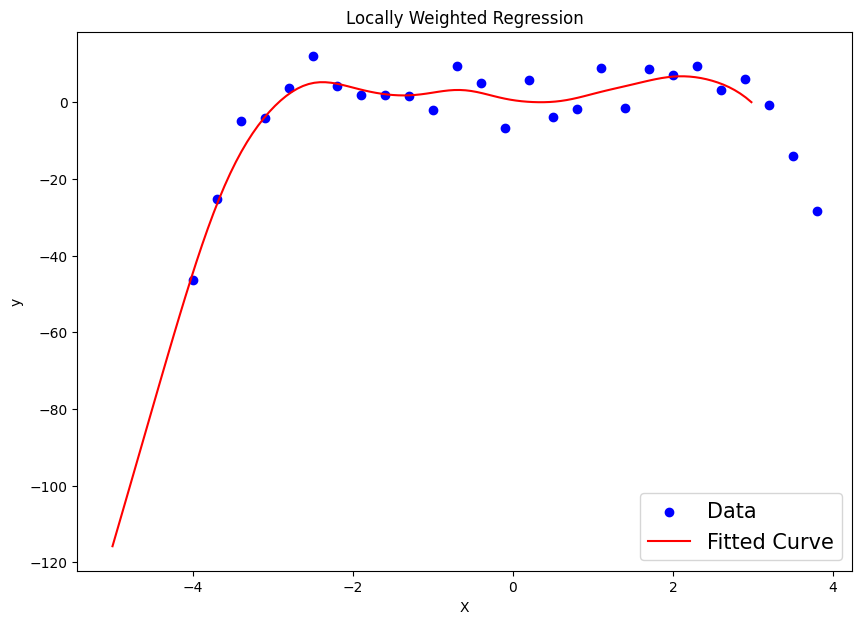

In [9]:
# x_pred = np.arange(-5, 3, 0.07)  # Points to predict

x_pred = np.arange(-5, 3, 0.07)

x_pred_with_ones = add_ones(x_pred.reshape(-1,1))

tau = 0.4  # Bandwidth parameter

lw_reg = LocallyWeightedRegression(tau)

lw_reg.fit(x_train, y_train)

y_pred = lw_reg.predict(x_pred_with_ones)
print(y_pred)


lw_reg.plot(x_pred, y_pred)

Plot the prediction output

In [10]:
def plot(x_train, y_train, x_pred, y_pred):
  plt.figure()
  plt.plot(x_train, y_train, 'bx', label='label')
  plt.plot(x_pred, y_pred, 'ro', label='prediction')
  plt.suptitle("Training Set", fontsize=12)
  plt.legend(loc='upper left')

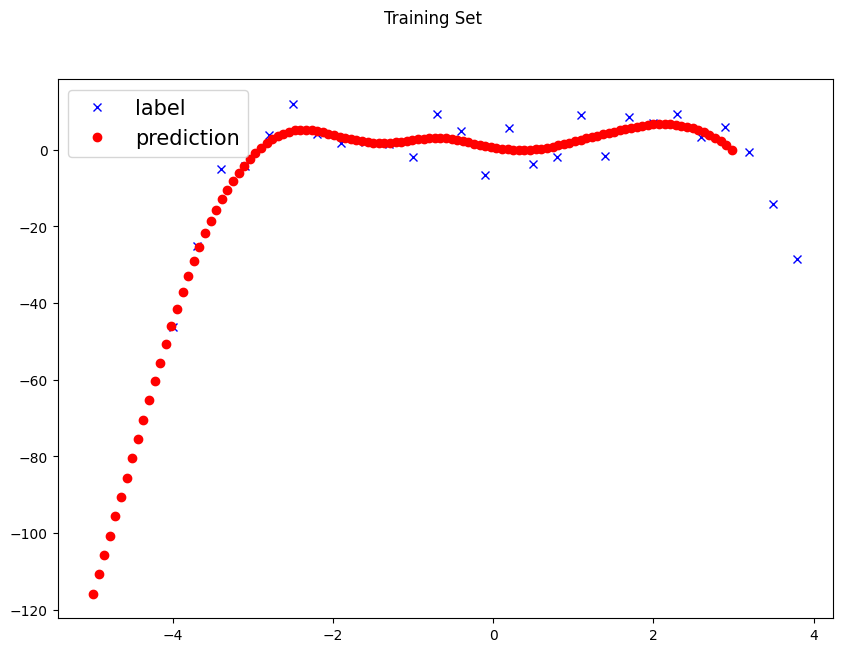

In [11]:
# Use the plot function
x_train_with_ones = add_ones(x_train)
plot(x_train, y_train, x_pred, y_pred)

In [12]:
# How tau affect the solution?
# Try different values of tau and observe the effect on the prediction by plotting them as above
# Write on observations as comment in the next cell

In [13]:
# Your comments

- How does $\tau$ affect the solution:
1. $\tau$ controls the smoothness of the predicted curv. In deed,

-  For values of $\tau$ close to $0$ (e.g $\tau = .1$), the predicted curve becomes wigly, i.e non-smooth. This also shows that the model fits a straight line between two closest pairs of points.

- For values of $\tau$ (e.g $0.9$) close to 1, the predicted curve becomes very smooth.
- For more larger values of $\tau$ (e.g $20$), the predicted curve becomes a straight-line. Hence, it fails to capture very well most of the  the data points.

2. Moreover,  some values of $\tau$ (e.g $0.04$) makes the matrix $(X^T W X)$ to be singular. Hence, this does not allow to make predictions unless a regulrization term is added, as follow:
$$\theta = (X^T W X + \alpha I)^{-1} X^T W y$$
where  $alpha$ some positive real number.

In the code, when the 'error' occur, we have to fit two more parameters:
`without_reg = False` and `alpha = some_number` in order to make prediction in general case.




# Robustness to outliers

Locally weighting regression is better in handling outlier because the weighting function will give it a small weights

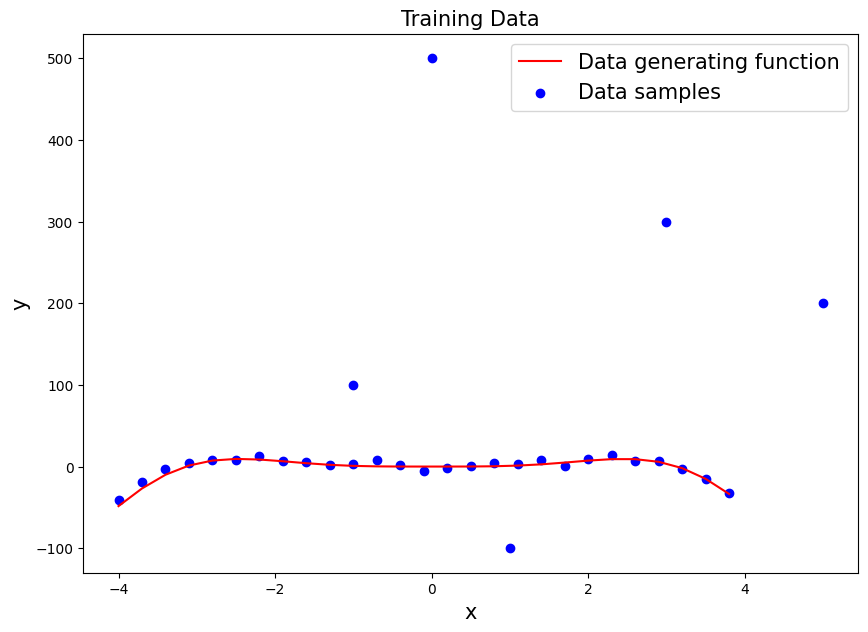

In [14]:
# Generate dataset with
x_train_with_outliers, y_train_with_outliers = generate_data(add_outlier=True)

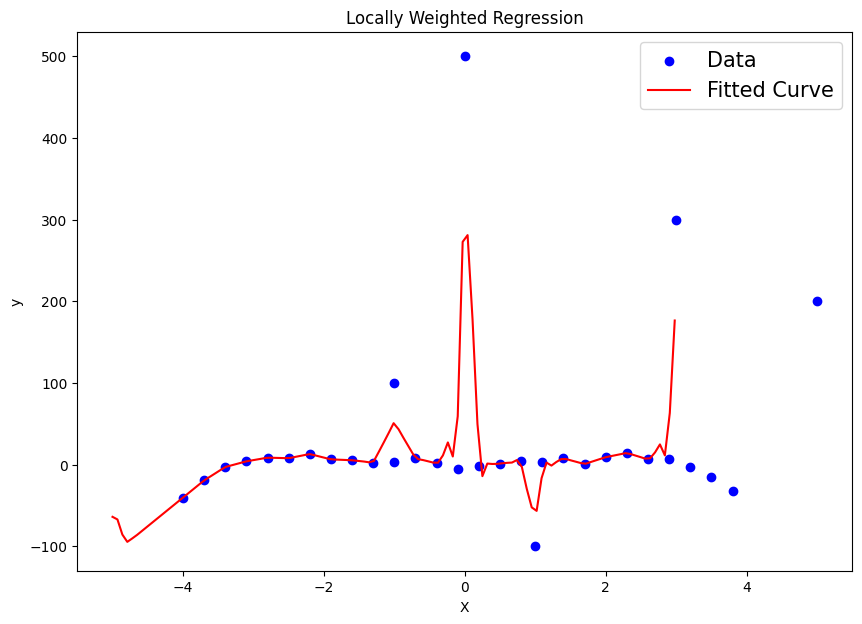

In [23]:
# train LWR on the new data and save the prediction values
# lwr_preds = None
##### write your code here #####

x_pred = np.arange(-5, 3, 0.07) # Points to predict
x_pred_with_ones = add_ones(x_pred.reshape(-1,1))
x_pred_with_ones
tau = 0.1  # Bandwidth parameter

lw_reg = LocallyWeightedRegression(tau)

lw_reg.fit(x_train_with_outliers, y_train_with_outliers)

lwr_preds = lw_reg.predict(x_pred_with_ones)

lw_reg.plot(x_pred, lwr_preds)


##### End of your code #####

In [16]:
# compare the results with a linear regression model
from sklearn.linear_model import LinearRegression
##### write your code here #####
reg = LinearRegression().fit(x_train.reshape(-1, 1), y_train.reshape(-1, 1), )
linear_reg_preds = reg.predict(x_pred.reshape(-1, 1))
##### End of your code #####

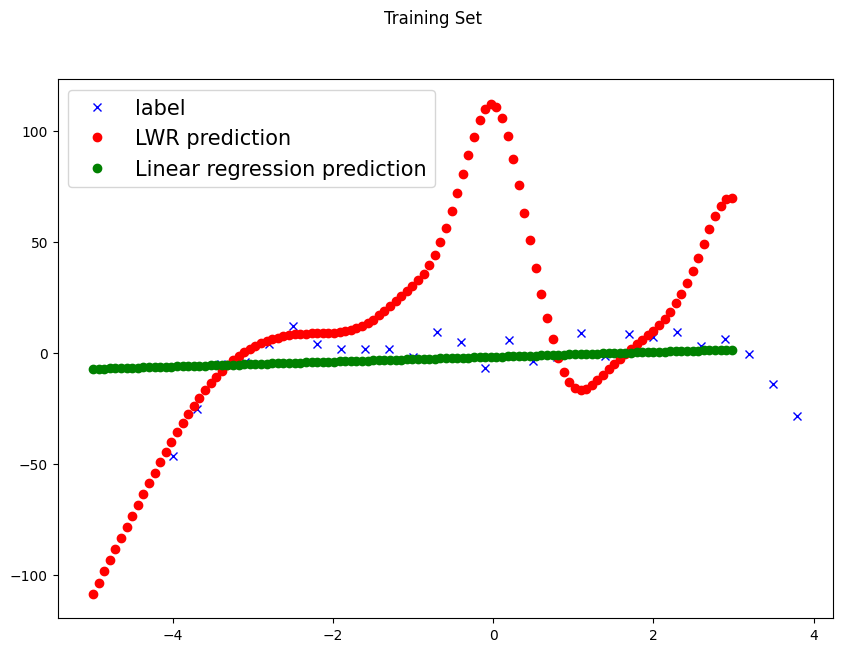

In [17]:
# Plot the predictins from LWR and linear regresson
plt.figure()
plt.plot(x_train, y_train, 'bx', label='label')
plt.plot(x_pred, lwr_preds, 'ro', label='LWR prediction')
plt.plot(x_pred, linear_reg_preds, 'go', label='Linear regression prediction')
plt.suptitle("Training Set", fontsize=12)
plt.legend(loc='upper left')

In [18]:
# How tau affect the sensitivity to outliers?
# Try different values of tau and observe the effect on the prediction by plotting them as above
# Write on observations as comment in the next cell

In [19]:
# Your comments

- How does $tau$ affect the sensitivity to outliers?

1. For small values of $\tau$ (e.g $ 0.1$) close to zero, the predicted curve strechtes towards the outlines, i.e it points towards these points. Then, it becomes non- smooth.
2. For larger values of $\tau$ (e.g $  0.9$) the predicted curve is smooth and doest not essentially point towards outliers.

## Others

*   Original Paper : https://sites.stat.washington.edu/courses/stat527/s14/readings/Cleveland_Delvin_JASA_1988.pdf

